In [1]:
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from deap import base, creator, tools, algorithms
from tensorflow.keras.applications import MobileNetV2
import pandas as pd
import cv2

2024-03-22 00:43:47.127714: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 00:43:47.127812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 00:43:47.262021: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Import Libraries 

In [2]:
import os
# Create an empty list to store the image paths and labels
data = []
# Loop through the benign folder and append the image paths and labels to the data list
for file in os.listdir('/kaggle/input/benign-and-malicious-qr-codes/QR codes/benign/benign'):
    data.append(['/kaggle/input/benign-and-malicious-qr-codes/QR codes/benign/benign/' + file, "benign"]) # 0 for benign label
# Loop through the malicious folder and append the image paths and labels to the data list
for file in os.listdir('/kaggle/input/benign-and-malicious-qr-codes/QR codes/malicious/malicious'):
    data.append(['/kaggle/input/benign-and-malicious-qr-codes/QR codes/malicious/malicious/' + file, "malicious"]) # 1 for malicious label
    
print(f"Total Images is {len(data)}")

Total Images is 200000


# Creae a DataFrame to hold Images paths and labels

In [3]:
df = pd.DataFrame(data, columns=['image', 'label'])
# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)
# Check the dataframe
df.head()

,image,label
0,/kaggle/input/benign-and-malicious-qr-codes/QR...,malicious
1,/kaggle/input/benign-and-malicious-qr-codes/QR...,benign
2,/kaggle/input/benign-and-malicious-qr-codes/QR...,malicious
3,/kaggle/input/benign-and-malicious-qr-codes/QR...,benign
4,/kaggle/input/benign-and-malicious-qr-codes/QR...,benign


# Check For Image Shape

In [4]:
import cv2
img = cv2.imread(df["image"][1])
print(img.shape)

(410, 410, 3)


Total benign images: 100000
Total malicious images: 100000


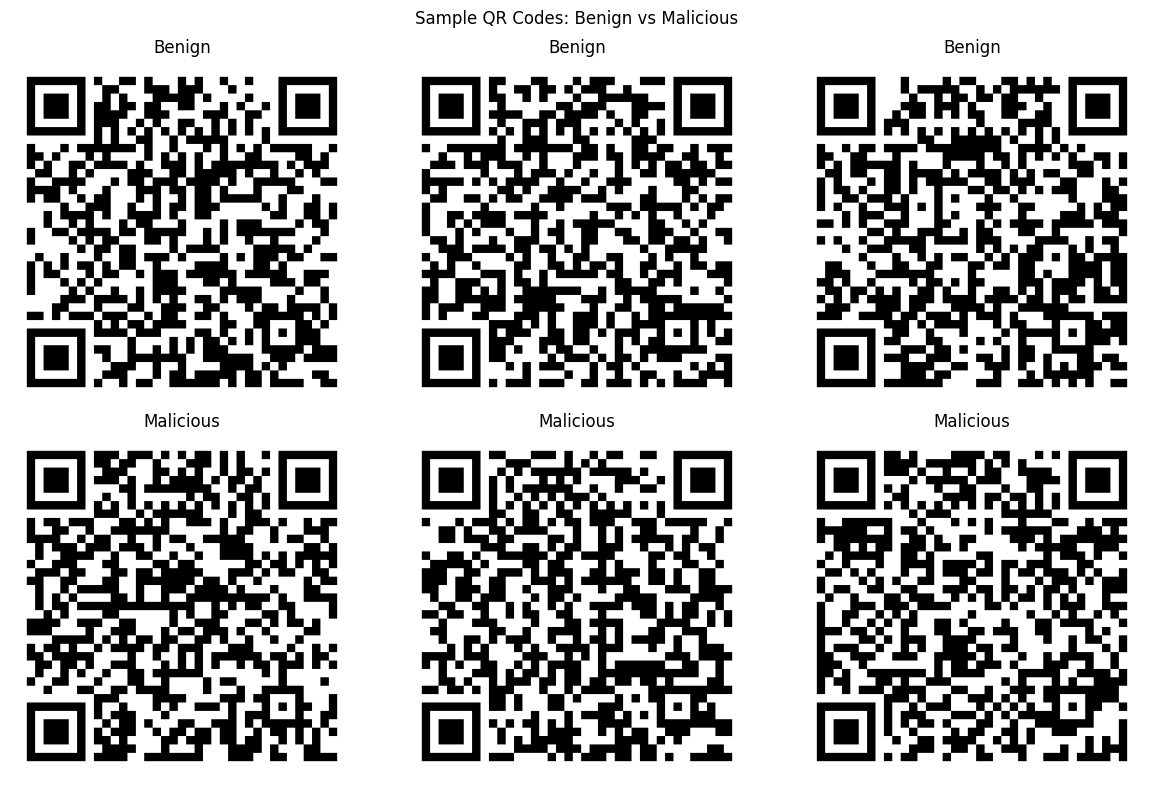

In [5]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Assuming 'data' is already defined from your provided code snippet

# Basic Dataset Statistics
benign_count = sum(1 for _, label in data if label == "benign")
malicious_count = sum(1 for _, label in data if label == "malicious")
print(f"Total benign images: {benign_count}")
print(f"Total malicious images: {malicious_count}")

# Sample Visualization
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Sample QR Codes: Benign vs Malicious')

for i in range(3):
    # Adjust the path as necessary to point to your actual image files
    benign_img_path = data[i][0]
    malicious_img_path = data[benign_count + i][0]
    
    benign_img = Image.open(benign_img_path)
    malicious_img = Image.open(malicious_img_path)
    
    axes[0, i].imshow(benign_img)
    axes[0, i].set_title('Benign')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(malicious_img)
    axes[1, i].set_title('Malicious')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [6]:
sample_img_path = data[0][0]  # Example for the first image
img = Image.open(sample_img_path)
print(f"Sample Image Dimensions: {img.size}")  # (width, height)
print(f"Color Mode: {img.mode}")  # e.g., "RGB"

Sample Image Dimensions: (410, 410)
Color Mode: 1


# Image Resizing and Spliting

In [7]:
# Lists to store images
benign_images = []
malicious_images = []

# Loop through DataFrame and load images
for _, row in df.iterrows():
    img = cv2.imread(row['image'])  # Load image
    if img is not None:
        img = cv2.resize(img, (64, 64))  # Resize for uniformity, adjust size as needed
        if row['label'] == 'benign':
            benign_images.append(img)
        elif row['label'] == 'malicious':
            malicious_images.append(img)

# Convert lists to numpy arrays for machine learning processing
benign_images = np.array(benign_images)
malicious_images = np.array(malicious_images)

In [8]:
benign_labels = np.zeros(len(benign_images))
malicious_labels = np.ones(len(malicious_images))

In [28]:
# Combine the images and labels
X = np.concatenate((benign_images, malicious_images), axis=0)
y = np.concatenate((benign_labels, malicious_labels), axis=0)


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X_train[1].shape

(64, 64, 3)

# Extract Features using MovileNetV2

#### **> Note: We use only 5000 of 160000 Training images for experiment** [Change it if you need]

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load the MobileNetV2 model pre-trained on ImageNet data
model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

def extract_features(x_train):
    features = model.predict(x_train)
    flat = features.reshape((features.shape[0], -1))
    return features

# Example usage
features = extract_features(X_train[:5000])

157/157 [==============================] - 2s 5ms/step


In [42]:
X = features
y = y_train[:5000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Implementation of GA**

In [43]:
def initialize_population(number_of_features, population_size):
    population = np.random.randint(2, size=(population_size, number_of_features))
    return population

def calculate_fitness(individual, X_train, X_test, y_train, y_test):
    # Selecting features based on the individual
    features_to_use = np.where(individual == 1)[0]
    if len(features_to_use) == 0:
        return 0
    X_train_selected = X_train[:, features_to_use]
    X_test_selected = X_test[:, features_to_use]

    # Training a classifier with the selected features
    classifier = SVC(kernel="linear")
    classifier.fit(X_train_selected, y_train)
    predictions = classifier.predict(X_test_selected)

    # Calculating fitness as the accuracy of the classifier
    fitness = accuracy_score(y_test, predictions)
    return fitness

def selection(population, fitnesses, num_parents):
    parents = np.empty((num_parents, population.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitnesses == np.max(fitnesses))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = population[max_fitness_idx, :]
        fitnesses[max_fitness_idx] = -999999
    return parents

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint8(offspring_size[1]/2)
    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k % parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k + 1) % parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover):
    # Mutation changes a single gene in each offspring randomly.
    for idx in range(offspring_crossover.shape[0]):
        gene_idx = np.random.randint(offspring_crossover.shape[1])
        # The random value to be added to the gene.
        offspring_crossover[idx, gene_idx] = 1 - offspring_crossover[idx, gene_idx]
    return offspring_crossover

# Features Selection using GA 

In [44]:
# Genetic algorithm parameters
number_of_features = X_train.shape[1]
population_size = 10
num_parents = 5
num_generations = 2
best_outputs = []

# Initialize the population with randomly selected features
population = initialize_population(number_of_features, population_size)

for generation in range(num_generations):
    print(f"Generation : {generation}")
    fitnesses = np.array([calculate_fitness(individual, X_train, X_test, y_train, y_test) for individual in population])
    best_outputs.append(np.max(fitnesses))
    print(f"Best result : {np.max(fitnesses)}")

    # The best result in the current iteration
    parents = selection(population, fitnesses, num_parents)

    # Generating next generation using crossover
    offspring_crossover = crossover(parents, offspring_size=(population_size - parents.shape[0], number_of_features))

    # Adding some variations to the offspring using mutation
    offspring_mutation = mutation(offspring_crossover)

    # Creating the new population based on the parents and offspring
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]:, :] = offspring_mutation

# The best solution from the last generation
fitnesses = np.array([calculate_fitness(individual, X_train, X_test, y_train, y_test) for individual in population])
best_match_idx = np.where(fitnesses == np.max(fitnesses))

print("Best solution : ", population[best_match_idx, :][0][0])
print("Best solution fitness : ", fitnesses[best_match_idx][0])

Generation : 0
Best result : 0.7
Generation : 1
Best result : 0.7
Best solution :  [1 0 1 ... 0 1 1]
Best solution fitness :  0.7


# **Training Using GA and SVM**

In [83]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# Step 1: Extract the selected features based on the best solution
selected_features_indices = np.where(population[best_match_idx, :][0][0] == 1)[0]

# Step 2: Prepare the dataset with only the selected features
X_train_selected = X_train[:, selected_features_indices]
X_test_selected = X_test[:, selected_features_indices]

# Step 3: Train the SVM classifier on the filtered dataset
svm_classifier_GA = SVC(kernel='rbf',C=200)
svm_classifier_GA.fit(X_train_selected, y_train)

# Step 4: Evaluate the classifier
y_pred = svm_classifier_GA.predict(X_train_selected)
accuracy = accuracy_score(y_train, y_pred)

# Step 5: Print the accuracy
print(f'Accuracy of SVM classifier with selected features: {accuracy*100:.2f}%')

Accuracy of SVM classifier with selected features: 92.80%


# **Training Without GA**

In [85]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svm_classifier = SVC(kernel='rbf',C=20)
svm_classifier.fit(X_train, y_train)

# Step 4: Evaluate the classifier
y_pred = svm_classifier.predict(X_train)
accuracy_1 = accuracy_score(y_train, y_pred)

# Step 5: Print the accuracy
print(f'Accuracy of SVM classifier without GA: {accuracy_1*100:.2f}%')

Accuracy of SVM classifier without GA: 83.43%


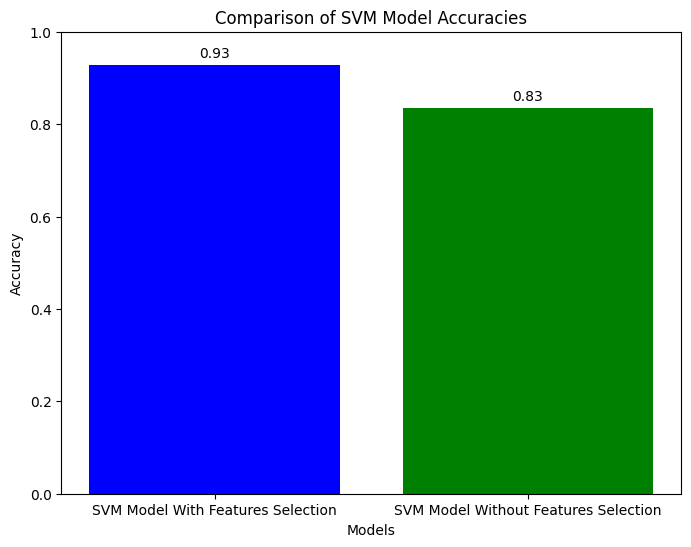

In [86]:
import matplotlib.pyplot as plt

# Example accuracies of two SVM models
accuracy_model_1 = accuracy
accuracy_model_2 = accuracy_1  # Model 2 accuracy (90%)

# Model names for the x-axis
models = ['SVM Model With Features Selection', 'SVM Model Without Features Selection']

# Accuracies for the y-axis
accuracies = [accuracy_model_1, accuracy_model_2]

# Creating the bar plot
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green'])

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of SVM Model Accuracies')
plt.ylim(0, 1)  # Assuming accuracy scores are between 0 and 1
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
plt.show()


# Testing on single Image

In [79]:
def prediction(path):
    img = cv2.imread(path)
    img = cv2.resize(img,(64,64))
    img = np.array(img)
    img = np.reshape(img,(1,64,64,3))
    model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
    img_features = model.predict(img)
    y_pred = svm_classifier_GA.predict(img_features[:, selected_features_indices])
    img = np.reshape(img,(64,64,3))
    if y_pred == 0:
        img_prediction = "Benign QR"
        plt.imshow(img)
        plt.title(img_prediction)
    else:
        img_prediction = "Malicious QR"
        plt.imshow(img)
        plt.title(img_prediction)

1/1 [==============================] - 1s 736ms/step


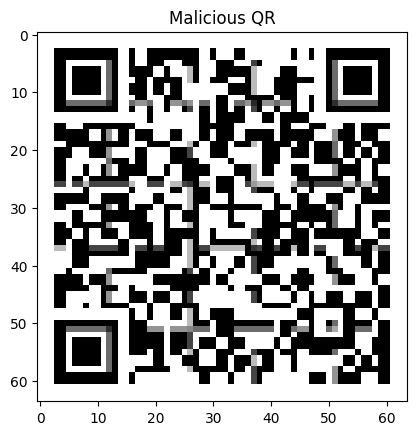

In [80]:
prediction("/kaggle/input/benign-and-malicious-qr-codes/QR codes/malicious/malicious/malicious_316281.png")